In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
BASE_DATA_PATH = 'trans.asc'

In [4]:
import dbscanmethod
import graphsmethod as graphmethod
import matrixmethod

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import trange, tqdm
import warnings
import swifter

warnings.filterwarnings("ignore")

In [5]:
params = list(range(10, 100, 10))

runs = []

N_RUNS = 10

In [6]:
df = pd.read_table(BASE_DATA_PATH, sep=';')
df = df.loc[~df.account.isna()] 
df.loc[:, 'account'] = df.loc[:, 'account'].astype(int)
df['payment_channel'] = df.account_id.astype(str) + '-' + df.account.astype(str) +'-' + df.operation.astype(str) + '-' + df.type.astype(str)
df['date'] =pd.to_datetime(df['date'].astype(str), format='%y%m%d')

posid = df.groupby(['payment_channel']).cumcount().rename('group_position')
df = df.join(posid)

data = df.copy()

In [7]:
cnts = data.groupby('payment_channel')['payment_channel'].count()
cnts = set(cnts[cnts > 100].index.tolist())

In [8]:
data = data.loc[data.payment_channel.isin(cnts)]

In [9]:
%%time
for i in range(N_RUNS):
    times = {
        'dbscan': [],
        'matrix': [],
        'graph': []
    }
    
    for method in ('dbscan', 'matrix', 'graph'):
        for i in params:#tqdm(params):
            print(f"Starting method {method.upper()} - With {i} points.")
            df = data.copy()
    
            df = df.groupby('payment_channel').tail(i)
    
            # Remove payment channels with too few transactions
            cnts = df.groupby('payment_channel')['payment_channel'].count().sort_values(ascending=True)
            df = df.loc[df['payment_channel'].isin(cnts[cnts > 4].index)]
            
            # compute diffdays
            lelele = df.sort_values(['payment_channel', 'date'])\
                .groupby('payment_channel')['date']\
                .diff(1).dt.days\
                .fillna(0)\
                .abs()
            
            df = df.join(lelele.rename('datediff'))
            
            df = df.sort_values(['payment_channel', 'date']).reset_index(drop=True)
            
                    
            start_time = time.time()
    
            if method == 'dbscan':
                df = dbscanmethod.main_dbscan_method(df, eps_date=.1, eps_amount=.3)
                df['cluster_id'] = (df['amount_lvl'].astype(int).astype(str)) + '-' +  df['day_cluster'].astype(int).astype(str)
    
            if method == 'graph':
                def flag_matrix(dates, amounts):    
                    dates = np.array(dates).astype(np.datetime64)
                    amounts = np.array(amounts)
    
                    datediffs_to_previous = np.diff(dates).astype('timedelta64[D]')
                    datediffs_to_previous = datediffs_to_previous/ np.timedelta64(1, 'D')
                    subseries = graphmethod.main_matrix_method_graphs(datediffs_to_previous, amounts, use_dbscan=False)
    
                    flags = np.ones(len(dates)) * -1
    
                    # Return array with subseries ids (eg: [0,1,1,1,1,1,0,0,2,0,2,2,2,2])
                    l = list(enumerate(subseries))
                    for i, indices in l:
                        flags[indices] = i
    
                    return flags
    
                def matrix_udf_graphs(data):
                    dates = data.date.values
                    amounts = data.amount.values
                    orders = data.group_position.values
    
                    subseries_ids = flag_matrix(dates, amounts)
    
                    return pd.Series({'cluster_id': subseries_ids, 'group_position': orders})
    
    
                bin_nbs = df.sort_values(['payment_channel', 'date'])\
                    .groupby(['payment_channel'])\
                    .progress_apply(matrix_udf_graphs)\
                    .explode(['cluster_id', 'group_position'])
    
                df = pd.merge(df, bin_nbs, on=['payment_channel', 'group_position'])
                df['cluster_id'] = df.cluster_id.astype(int)
                df['is_rec'] = (df['cluster_id'] >= 0).astype(int)
                pass
    
            if method == 'matrix':
                def matrix_flag(data):
                    dates = data['date'].values
                    diff_days = data['date'].diff(1).dt.days.dropna().values
                    amounts = data['amount'].values
                    orders = data.group_position.values
    
                    #subseries = split_series_cluster(diff_days, amounts, dates, centroids)
                    subseries = matrixmethod.main_matrix_method(diff_days, amounts, use_dbscan=False)
    
                    flags = np.ones(len(data)) * -1
    
                    # Return array with subseries ids (eg: [0,1,1,1,1,1,0,0,2,0,2,2,2,2])
                    l = list(enumerate(subseries))
                    for i, indices in l:
                        flags[indices] = i
    
                    return pd.Series({'cluster_id': flags, 'group_position': orders})
    
                # Matrix Method
                bin_nbs = df.sort_values(['payment_channel', 'date'])\
                    .groupby(['payment_channel'])\
                    .progress_apply(matrix_flag)\
                    .explode(['cluster_id', 'group_position'])
    
                df = pd.merge(df, bin_nbs, on=['payment_channel', 'group_position'])
                df['cluster_id'] = df.cluster_id.astype(int)
                df['is_rec'] = (df['cluster_id'] >= 0).astype(int)
                pass
    
            elapsed = time.time() - start_time
            times[method].append(elapsed)
    
    runs.append(times)
        

Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 258.37it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 202.72it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 147.94it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 117.16it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 81.12it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 59.80it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 54.45it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 43.96it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 34.97it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 348.63it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 183.28it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 96.97it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 57.59it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 41.02it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 26.76it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 20.60it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 16.23it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.50it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 309.17it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 71.84it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.71it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  6.85it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:16<00:00,  2.82s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 263.03it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 204.35it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 148.63it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 116.29it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 82.96it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 59.91it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 51.33it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 44.81it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 34.75it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 353.39it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 177.14it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 100.72it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 58.85it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 38.53it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 28.40it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.59it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 16.08it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.29it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 317.20it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 71.39it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.67it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  7.58it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:16<00:00,  2.83s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 261.83it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 207.45it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 150.92it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 114.38it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 82.14it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 65.26it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 55.03it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 44.46it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 35.48it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 354.15it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 176.82it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 100.95it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 57.46it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 38.96it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 28.63it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.50it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 16.21it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.49it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 315.82it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 71.48it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.67it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  7.58it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 270.73it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 208.89it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 150.42it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 114.47it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 84.07it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 66.33it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 54.10it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 45.24it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 34.97it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 358.65it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 183.85it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 101.03it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 61.13it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 40.34it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 28.94it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.23it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 15.91it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.28it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 316.60it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 71.11it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.52it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  7.58it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 272.03it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 209.50it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 154.74it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 105.39it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 88.07it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 66.09it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 52.25it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 43.80it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 36.03it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 356.50it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 176.84it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 101.21it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 60.05it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 39.54it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 27.81it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.15it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 15.92it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.39it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 315.82it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 71.29it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.68it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 264.42it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 209.39it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 147.45it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 116.22it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 83.28it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 63.06it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 53.45it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 44.18it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 34.09it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 353.65it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 181.61it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 99.26it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 57.96it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 39.54it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 28.89it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.57it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 16.11it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.42it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 319.12it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 71.48it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.82it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  7.62it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 257.91it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 203.36it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 148.32it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 114.50it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 82.92it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 67.11it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 50.65it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 44.36it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 35.17it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 354.37it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 183.34it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 101.02it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 61.54it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 39.95it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 27.29it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.49it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 15.97it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 319.51it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 71.59it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.62it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  7.62it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 267.54it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 206.41it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 150.86it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 114.89it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 83.86it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 59.56it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 54.20it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 44.22it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 34.48it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 357.36it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 176.86it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 95.34it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 56.59it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 40.55it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 29.03it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.47it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 16.61it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.62it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 315.97it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 71.43it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.83it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  7.63it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 264.90it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 206.53it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 153.26it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 116.52it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 88.92it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 65.91it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 55.27it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 43.51it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 36.74it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 359.62it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 175.94it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 100.85it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 58.98it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 38.84it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 28.34it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.39it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 15.84it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.44it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 315.20it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 70.92it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.34it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  7.63it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.00it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:17<00:00,  2.88s/it]


Starting method DBSCAN - With 10 points.


100%|██████████| 10/10 [00:00<00:00, 270.33it/s]


Starting method DBSCAN - With 20 points.


100%|██████████| 11/11 [00:00<00:00, 211.18it/s]


Starting method DBSCAN - With 30 points.


100%|██████████| 11/11 [00:00<00:00, 151.72it/s]


Starting method DBSCAN - With 40 points.


100%|██████████| 11/11 [00:00<00:00, 116.75it/s]


Starting method DBSCAN - With 50 points.


100%|██████████| 11/11 [00:00<00:00, 82.40it/s]


Starting method DBSCAN - With 60 points.


100%|██████████| 11/11 [00:00<00:00, 67.47it/s]


Starting method DBSCAN - With 70 points.


100%|██████████| 11/11 [00:00<00:00, 52.67it/s]


Starting method DBSCAN - With 80 points.


100%|██████████| 11/11 [00:00<00:00, 43.64it/s]


Starting method DBSCAN - With 90 points.


100%|██████████| 11/11 [00:00<00:00, 34.69it/s]


Starting method MATRIX - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 363.12it/s]


Starting method MATRIX - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 178.80it/s]


Starting method MATRIX - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 101.62it/s]


Starting method MATRIX - With 40 points.


100%|██████████| 6/6 [00:00<00:00, 58.86it/s]


Starting method MATRIX - With 50 points.


100%|██████████| 6/6 [00:00<00:00, 39.14it/s]


Starting method MATRIX - With 60 points.


100%|██████████| 6/6 [00:00<00:00, 28.60it/s]


Starting method MATRIX - With 70 points.


100%|██████████| 6/6 [00:00<00:00, 21.97it/s]


Starting method MATRIX - With 80 points.


100%|██████████| 6/6 [00:00<00:00, 16.72it/s]


Starting method MATRIX - With 90 points.


100%|██████████| 6/6 [00:00<00:00, 13.53it/s]


Starting method GRAPH - With 10 points.


100%|██████████| 6/6 [00:00<00:00, 319.46it/s]


Starting method GRAPH - With 20 points.


100%|██████████| 6/6 [00:00<00:00, 72.16it/s]


Starting method GRAPH - With 30 points.


100%|██████████| 6/6 [00:00<00:00, 20.63it/s]


Starting method GRAPH - With 40 points.


100%|██████████| 6/6 [00:00<00:00,  7.62it/s]


Starting method GRAPH - With 50 points.


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Starting method GRAPH - With 60 points.


100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


Starting method GRAPH - With 70 points.


100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Starting method GRAPH - With 80 points.


100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Starting method GRAPH - With 90 points.


100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

CPU times: user 7min 25s, sys: 2.68 s, total: 7min 28s
Wall time: 7min 25s


In [10]:
import pickle

with open('runtimes.pkl', 'wb') as file:
    pickle.dump(runs, file)

In [ ]:
import pickle

with open('runtimes.pkl', 'r') as file:
    runs = pickle.load(file)

In [12]:
import mercury.viz

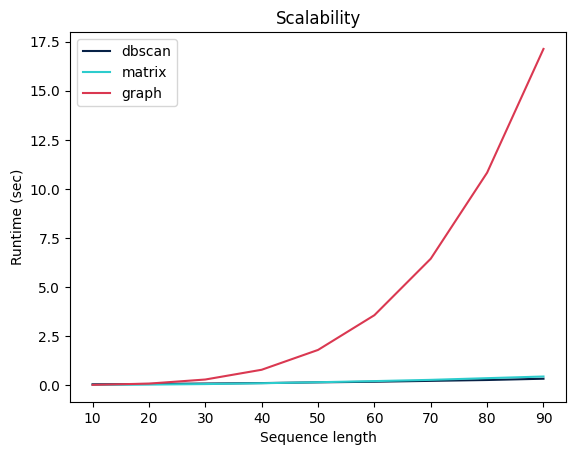

In [13]:
fig, ax = plt.subplots()

ax.plot(params[:len(times['dbscan'])], times['dbscan'], label='dbscan', color='bbva:navy')
ax.plot(params[:len(times['matrix'])], times['matrix'], label='matrix', color='bbva:aqua')
ax.plot(params[:len(times['graph'])], times['graph'], label='graph', color='bbva:red')

ax.set_xlabel('Sequence length')
ax.set_ylabel('Runtime (sec)')
ax.set_title('Scalability')
ax.legend()

In [40]:
mean_dbscan = np.array([r['dbscan'] for r in runs]).mean(axis=0)
errors_dbscan = np.array([r['dbscan'] for r in runs]).std(axis=0)

mean_graph = np.array([r['graph'] for r in runs]).mean(axis=0)
errors_graph = np.array([r['graph'] for r in runs]).std(axis=0)

mean_matrix = np.array([r['matrix'] for r in runs]).mean(axis=0)
errors_matrix = np.array([r['matrix'] for r in runs]).std(axis=0)

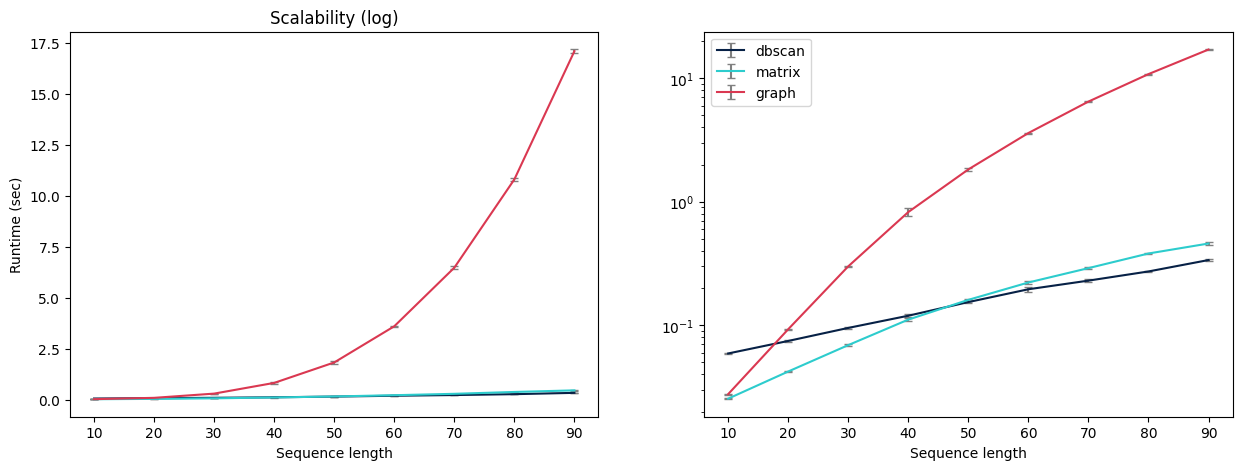

In [47]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].errorbar(params[:len(times['dbscan'])], mean_dbscan, yerr=errors_dbscan, fmt='', color='bbva:navy', ecolor='gray', capsize=3, label='dbscan')
ax[0].errorbar(params[:len(times['matrix'])], mean_matrix, yerr=errors_matrix, fmt='', color='bbva:aqua', ecolor='gray', capsize=3, label='matrix')
ax[0].errorbar(params[:len(times['graph'])], mean_graph, yerr=errors_graph, fmt='', color='bbva:red', ecolor='gray', capsize=3, label='graph')

ax[1].errorbar(params[:len(times['dbscan'])], mean_dbscan, yerr=errors_dbscan, fmt='', color='bbva:navy', ecolor='gray', capsize=3, label='dbscan')
ax[1].errorbar(params[:len(times['matrix'])], mean_matrix, yerr=errors_matrix, fmt='', color='bbva:aqua', ecolor='gray', capsize=3, label='matrix')
ax[1].errorbar(params[:len(times['graph'])], mean_graph, yerr=errors_graph, fmt='', color='bbva:red', ecolor='gray', capsize=3, label='graph')

ax[0].set_xlabel('Sequence length')
ax[0].set_ylabel('Runtime (sec)')
ax[0].set_title('Scalability')

ax[0].set_title('Scalability (log)')
ax[1].set_xlabel('Sequence length')
ax[1].set_yscale('log')

ax[1].legend()